In [17]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import solve_ivp
from lmfit import minimize, Parameters, report_fit
import pandas as pd
from scipy.constants import N_A

In [18]:
Target_cell_number = 2e5
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60*10
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]
z0 = [0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
reaction_volume = (2/3)*math.pi*((r_ab)**3)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [19]:
def model_S_monospecific(t, z, Ainit, rtot, kon, koff, k2):
     k = Ainit*kon
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0/rtot) - koff*z[0] - (k2*Ag*z[0]/rtot) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]/rtot) - 2*koff*z[1]

     return [dA10, dA11]

def solve_ode(x, params, i):

    solution_vals = np.zeros_like(x)
    if i == 0 or i==1:
        rtot = params[f'rtot_{i+1}']
        kon = params[f'kon_{i+1}']
        k2 = params[f'k2_{i+1}']
        koff = params[f'koff_{i+1}']

        
    
        for j, val in enumerate(x):
            A0 = 1e-9*val
            z = solve_ivp(model_S_monospecific, tspan, z0, method='Radau', t_eval=t, args=(A0, rtot, kon,
                                                                                            koff, k2))
        
            A10 = z.y[0]
            A11 = z.y[1]
            A10_STST = A10[-1]
            A11_STST = A11[-1]

            Ag1 = (rtot - A10_STST - 2*A11_STST)/rtot
        
            solution_vals[j] = Ag1
    
    if i ==2:
        rtot1 = params[f'rtot_{1}']
        kon1 = params[f'kon_{1}']
        k21 = params[f'k2_{1}']
        koff1 = params[f'koff_{1}']

        rtot2 = params[f'rtot_{2}']
        kon2 = params[f'kon_{2}']
        k22 = params[f'k2_{2}']
        koff2 = params[f'koff_{2}']

        for j, val in enumerate(x):
            A0 = 1e-9*val

            z = solve_ivp(model_S_monospecific, tspan, z0, method='Radau', t_eval=t, args=(A0, rtot1, kon1,
                                                                                            koff1, k21))
            w = solve_ivp(model_S_monospecific, tspan, z0, method='Radau', t_eval=t, args=(A0, rtot2, kon2,
                                                                                            koff2, k22))
            
            P_A10 = z.y[0]
            P_A11 = z.y[1]
            C_A10 = w.y[0]
            C_A11 = w.y[1]
            P_A10_STST = P_A10[-1]
            P_A11_STST = P_A11[-1]
            C_A10_STST = C_A10[-1]
            C_A11_STST = C_A11[-1]

            Ab = 1 - (((rtot1 - P_A10_STST - 2*P_A11_STST) + (rtot2 - C_A10_STST - 2*C_A11_STST))/(rtot1 + rtot2))
            solution_vals[j] = Ab

    
    

    return np.asarray(solution_vals)

def objective(params, x, data):
    ndata =  data.shape[0]
    resid = 0.0*data[:]

    for i in range(ndata):
        resid[i][:] = data[i][:] - solve_ode(x, params, i)
    
    return resid.flatten()

In [20]:
df = pd.read_csv('Mazor_monospecific_40_1.csv')
df1 = df[['Dataset_pd1', 'Unnamed: 1']]
x_data_pd1_40 = np.asarray(df1['Dataset_pd1'])
y_data_pd1_40 = np.asarray(df1['Unnamed: 1'])/100

df2 = df[['Dataset_ctla4', 'Unnamed: 3']]
y_data_ctla4_40 = np.asarray(df2['Unnamed: 3'])/100

df3 = df[['Dataset_ab_binding', 'Unnamed: 5']]
y_data_ab_40 = np.asarray(df3['Unnamed: 5'])/100

data_40_1_exper = [y_data_pd1_40, y_data_ctla4_40, y_data_ab_40]
data_40_1_exper = np.array(data_40_1_exper)

In [21]:
from scipy.interpolate import interp1d

interp_func_pd1 = interp1d(x_data_pd1_40, y_data_pd1_40)
interp_func_ctla = interp1d(x_data_pd1_40, y_data_ctla4_40)
interp_func_ab = interp1d(x_data_pd1_40, y_data_ab_40)

A0s1 = [1e-11, 1e-10, 1e-9, 1e-8]
A0s = []
vals = np.linspace(1, 9, 10)
for x in A0s1:
    for val in vals:
        A0s.append(x*val)
A0s1 = np.asarray(A0s)/1e-9
xdata = np.concatenate((x_data_pd1_40, A0s1))
y_data_pd1 = np.concatenate((y_data_pd1_40, interp_func_pd1(A0s1)))
y_data_ctla4 = np.concatenate((y_data_ctla4_40, interp_func_ctla(A0s1)))
y_data_ab = np.concatenate((y_data_ab_40, interp_func_ab(A0s1)))
data_40_1 = [y_data_pd1, y_data_ctla4, y_data_ab]
data_40_1 = np.array(data_40_1)

In [22]:
fit_params = Parameters()

fit_params.add(f'rtot_{1}', value = 1e2, min=0, max = 1e7)
fit_params.add(f'rtot_{2}', value = 1e2, min=0, max = 1e7)
fit_params.add(f'kon_{1}', value = 1e5, min=1e3, max = 1e7)
fit_params.add(f'kon_{2}', value = 1e5, min=1e3, max = 1e7)
fit_params.add(f'k2_{1}', value = 100, min=0, max = 1e3)
fit_params.add(f'k2_{2}', value = 100, min=0, max = 1e3)
fit_params.add(f'koff_{1}', value = 1,  min=0, max = 1)
fit_params.add(f'koff_{2}', value = 1, min=0, max = 1)


fit_params[f'rtot_{1}'].expr = f'40.0*rtot_{2}'


def SquaredError(InitialParameterGuess):
    print(InitialParameterGuess)
    fit_params[f'rtot_{1}'].value = InitialParameterGuess[0]
    fit_params[f'rtot_{2}'].value = InitialParameterGuess[1]
    fit_params[f'kon_{1}'].value = InitialParameterGuess[2]
    fit_params[f'kon_{2}'].value = InitialParameterGuess[3]
    fit_params[f'k2_{1}'].value = InitialParameterGuess[4]
    fit_params[f'k2_{2}'].value = InitialParameterGuess[5]
    fit_params[f'koff_{1}'].value = InitialParameterGuess[6]
    fit_params[f'koff_{2}'].value = InitialParameterGuess[7]
    try:
        print('here')
        out = minimize(objective, fit_params, args=(xdata, data_40_1), max_nfev=200)
        print('here1')
        error = []
        for i, solution in enumerate(data_40_1):
            y_fit = solve_ode(A0s1, out.params, i)
            for j in range(len(y_fit)):
                err_val = (y_fit[j] - solution[j])**2
                error.append(err_val)
            

    except RuntimeError:
        error = [1e10, 1e10]

    return sum(error)

def RandomSearch(Iterations):

    nIt = Iterations
    GuessContainer = []
    ErrorContainer = []
    for k in range(nIt):
        print(k)
        lguess = [np.random.uniform(low=0, high = 1e4) for val in range(2)]
        lguess.append(np.random.uniform(low =1e2, high = 1e5))
        lguess.append(np.random.uniform(low =1e2, high = 1e5))
        lguess.append(np.random.uniform(low =1, high = 100))
        lguess.append(np.random.uniform(low =1, high = 100))
        lguess.append(np.random.uniform(low =0, high = 1))
        lguess.append(np.random.uniform(low =0, high = 1))
        lerror = SquaredError(lguess)
        GuessContainer.append(lguess)
        ErrorContainer.append(lerror)
    minError = np.min(ErrorContainer)
    minLocation = [j for j in range(nIt) if ErrorContainer[j] == minError]
    bestGuess=GuessContainer[minLocation[0]]

    return ErrorContainer, bestGuess


In [23]:
out = minimize(objective, fit_params, args=(xdata, data_40_1))
report_fit(out.params)

[[Variables]]
    rtot_1:  3902621.41 +/- 2261137.34 (57.94%) == '40.0*rtot_2'
    rtot_2:  97565.5353 +/- 56528.4337 (57.94%) (init = 100)
    kon_1:   90391.7674 +/- 832113.395 (920.56%) (init = 100000)
    kon_2:   9534.07362 +/- 50662.3198 (531.38%) (init = 100000)
    k2_1:    999.997128 +/- 20.1196695 (2.01%) (init = 100)
    k2_2:    614.936404 +/- 2541.41811 (413.28%) (init = 100)
    koff_1:  0.32484275 +/- 1.48635261 (457.56%) (init = 1)
    koff_2:  0.34649078 +/- 1.13925410 (328.80%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kon_1, koff_1) = 0.994
    C(kon_2, koff_2) = 0.775
    C(k2_2, koff_2)  = 0.596
    C(k2_1, koff_1)  = -0.527
    C(kon_1, k2_1)   = -0.518
    C(rtot_2, kon_1) = 0.130
    C(rtot_2, kon_2) = 0.109


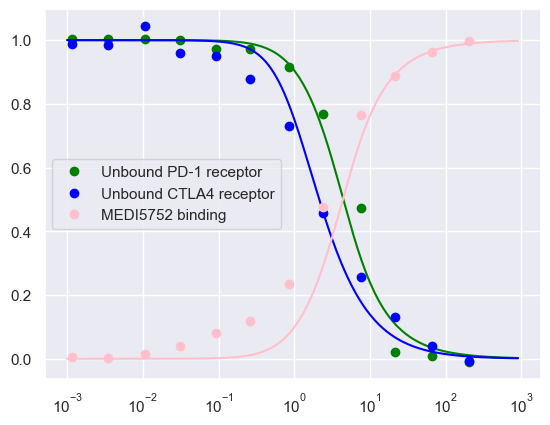

In [24]:
A0s1 = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
A0s = []
vals = np.linspace(1, 9, 50)

import seaborn as sns
sns.set_theme()
for x in A0s1:
    for val in vals:
        A0s.append(x*val)
A0s1 = np.asarray(A0s)/1e-9
colors = ['green', 'blue', 'pink']
labels = ['Unbound PD-1 receptor', 'Unbound CTLA4 receptor', 'MEDI5752 binding']
for i, solution in enumerate(data_40_1):
    y_fit = solve_ode(A0s1, out.params, i)

    plt.plot(x_data_pd1_40, data_40_1_exper[i], 'o', color=colors[i], label=labels[i])
    plt.plot(A0s1, y_fit, color=colors[i])

plt.legend(loc='best')
plt.xscale('log')
plt.show()